# CBF Tutorial
### Authors: Bardh, Tom and Shakiba

### In this notebook, we present a short introduction on Control Barrier Functions.

First, let's start by defining a two-dimensional system, called **nimble_ant**, with the following dynamics: 

\begin{align}
  \dot{x} &= \begin{bmatrix}u_0 \\ u_1\end{bmatrix} \tag{1}\\
\end{align}

Given an initial position 
\begin{align*}
x^{init} = \begin{bmatrix} x^{init}_0 \\  x^{init}_1 \end{bmatrix} \tag{2}\\
\end{align*}
our goal is to control this system to a goal location $x^{goal}$. However, the system should avoid certain areas in the workspace (more on this later). 

One way to solve this problem is to pose it as an optimization problem. Specifically, we would like to solve the following problem:
\begin{align*}
\min_{u} \quad & ||u_{ref} - u||\\
\textrm{s.t.} \quad & \text{CBF constraints to be added later} \tag{3}\\
\end{align*}
So, we will try to minimize the distance between the decission variable $u$ and reference controller $u_{ref}$, while satisfying some constraints. For now, let us disregard the constraint and focus on designing a reference controller. 

### Reference controller

We will define a very simple reference controller as follows
\begin{align*}
u_{ref} = k \cdot (x^{goal} - x) \tag{4}
\end{align*}
This is a two dimensional vector that takes the difference between the current system state (or location) and the goal location and multiply it with a gain factor $k$. This **simple** reference controller will take us from an initial location to the goal location. We can say it is a typical [proportional controller](https://en.wikipedia.org/wiki/Proportional_control). Next, we need to make sure that the system does not enter undesired states. 

### Control Barrier Function (CBF) as Constraints

We assume that the undesired regions in the workspace can be defined with one or more [ellipses](https://en.wikipedia.org/wiki/Ellipse). In two dimensions, the region inside an ellypsis can be using the standard form with the following inequality
\begin{align*}
\frac{z^2_0}{a^2} + \frac{z^2_1}{b^2}\leq 1 \tag{5}
\end{align*}
where $z_0,z_1$ define the origin and $a,b$ define the major, minor axes of the ellipse, respectively. 

In our case, we would like to check whether our system is in the undesired region and therefore we modify the afforementined requirement 
\begin{align*}
B(x) = \frac{(x_0-z_0)^2}{a^2} + \frac{(x_1-z_1)^2}{b^2} - 1 \tag{6}
\end{align*}

CBFs are defined by the condition:
\begin{align}
\dot{B}(x) \ge -\alpha\cdot(B(x)) \tag{7}
\end{align}

Where $\dot{B}(x) = \frac{\partial{B}}{\partial{t}}$ and $\alpha$ is a positive real value. In this example we set $\alpha=1$. $\dot{B}(x)$ indicates how the distance of the system to the barrier changes with respect to time. 

So, in our formulation  $B(x) < 0$ indicates whether the current state is in a unsafe set.
For a more detailed explanation of Eq. (7) See Proposition 2 in "[Safety Verification of Hybrid Systems Using Barrier Certificates](http://web.mit.edu/~jadbabai/www/papers/hscc04_2.pdf)".
In Eq. (7), $B(x)$ indicates the distance between the state of the system and the unsafe set.
We need to ensure that the rate of change is always bigger than the distance to the bad set by a factor $\alpha$.
In our case $\alpha$ is one but in other problems it can be different.
If this inequality holds, then the system is forward invariant. It will not enter the bad set.
Next, we need to find a way to introduce our control input into this equation so that we can ensure that this inequality remains true. We do so through by subsituting $\dot{B}(x)$ with an equivalent expression in terms of the control input. 

In order to calculate $\dot{B}(x)$, we utilize the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), which allows us to write
\begin{align*}
\dot{B}(x) = \frac{\partial{B}}{\partial{x}} \cdot \frac{\partial{x}}{\partial{t}} \tag{8}
\end{align*}

Since $\frac{\partial{x}}{\partial{t}} = \dot{x}$, then
\begin{align*}
\dot{B}(x) = \frac{\partial{B}}{\partial{x}} \cdot \dot{x} \tag{9}
\end{align*}
This we can easily solve by taking the derivative of $B(x)$ with respect to $x$
\begin{align*}
\frac{\partial{B}}{\partial{x}} = \begin{bmatrix} \frac{2}{a^2}(x_0 - z_0) \\ \frac{2}{b^2}(x_1 - z_1)\end{bmatrix}  \tag{10}
\end{align*}
(The expansion is [here](./derivativeB.ipnyb))

Plugging this back in the original equation (7), since (9), (10), $\alpha=1$, we get

\begin{align*}
\dot{B}(x) &\ge -\alpha\cdot(B(x))\\
\equiv \frac{\partial{B}}{\partial{x}} \dot{x} &\ge -\alpha\cdot(B(x))\\
\equiv \begin{bmatrix} \frac{2}{a^2}(x_0 - z_0) \\ \frac{2}{b^2}(x_1 - z_1)\end{bmatrix} \dot{x} &\ge -(\frac{(x_0-z_0)^2}{a^2} + \frac{(x_1-z_1)^2}{b^2} - 1) \tag{11}
\end{align*}

This will be used as a constraint for one ellipse. If there are additional ellipses in the workspace, we can add more CBFs in a similar fashion.

### Posing the control problem as a quadratic program

We can now combine the cost function with the constraints to form an optimization problem. 

\begin{align*}
\min_{u} \quad & ||u_{ref} - u||\\
\textrm{s.t.} \quad & \begin{bmatrix} \frac{2}{a^2}(x_0 - z_0) \\ \frac{2}{b^2}(x_1 - z_1)\end{bmatrix} \dot{x} \ge -(\frac{(x_0-z_0)^2}{a^2} + \frac{(x_1-z_1)^2}{b^2} - 1) \\
... \tag{12}
\end{align*}

This problem can be posed as a [quadratic problem](https://en.wikipedia.org/wiki/Quadratic_programming) of the form 

\begin{align*}
\min \quad & \frac{1}{2}\mathbf{x}^T P\mathbf{x} + q^T\mathbf{x} \\
\textrm{s.t.} \quad & G\mathbf{x} \le h \\
\quad & A\mathbf{x} = b \tag{13}
\end{align*}

Where $P = I_2$, $\mathbf{x} = \dot{x}$, the two-dimensional identity matrix and

$ q = \begin{bmatrix} -u_{ref0} \\  -u_{ref1} \end{bmatrix} \tag{14}$
$ G = \begin{bmatrix} \frac{-2}{a^2}(x_0 - z_0) \\ \frac{-2}{b^2}(x_1 - z_1)\end{bmatrix} \tag{15}$
$ h = (\frac{(x_0-z_0)^2}{a^2} + \frac{(x_1-z_1)^2}{b^2} - 1) \tag{16}$

(The expansion is [here](./CBF2quadratic.ipnyb))

Here, one of advantage of this methodology is that instance of controller is not needed, as we can see (14) referes only result of controller reference $u_{ref}$. In another word, the CBF can work as an observer in whole controll system.

### Code implementation

First, we import the necessary packages for our example. 



In [8]:
from sympy import symbols
import numpy as np
import matplotlib.pyplot as plt
import control as control
import cvxopt as cvxopt
from cbflib import cbf, cbf_utils, sys_and_ctrl

In cbflib, we have the [cbf.py](./cbflib/cbf.py), systems and controllers in [sys_and_ctrl](./cbflib/sys_and_ctrl.py), and sevearl utilities in [cbf_utils](./cbflib/cbf_utils.py). 

In [cbf.py](./cbflib/cbf.py) we define the CBF class, which enables us to define an instance of a CBF as well as compute the G and h matrices in the controller. 

In [sys_and_ctrl](./cbflib/sys_and_ctrl.py), we define systems and controllers for our examples including nimble_ant.



We define the goal for the system, bad sets, and parameters for the controller

In [9]:
# Robot Goal
x_goal = np.array([5, 5])

# Elipse format (x,y,rad_x,rad_y)
bad_sets = cbf_utils.example(2)

# Parameters for reference controller
ctrl_param_k = [0.3, 0.3]

We define the expression for the CBF, f(x) and g(x) for the dynamics of the system

In [10]:
# Symbols and equations for the CBF
x_0, x_1, z_0, z_1, a, b = symbols('x_0 x_1 z_0 z_1 a b')
symbs = (x_0, x_1, z_0, z_1, a, b)
B = ((x_0 - z_0)/a)**2 + ((x_1 - z_1)/b)**2 - 1

# ! placeholders for more complex functions
f, g = 1, 1

# Initialize CBF
my_CBF = cbf.CBF(B, f, g, (x_0, x_1), bad_sets, symbs)

We also define simulation options and define the closed loop system using the control package. 

In [11]:
# Simulation settings
T_max = 20
n_samples = 100
T = np.linspace(0, T_max, n_samples)

# System definition using the control toolbox
nimble_ant_sys = control.NonlinearIOSystem(
    sys_and_ctrl.nimble_ant_f, None, inputs=('u_0', 'u_1'), outputs=('x_0', 'x_1'), dt=None,
    states=('x_0', 'x_1'), name='nimble_ant_sys')

nimble_ant_ctrl = control.NonlinearIOSystem(
    None, sys_and_ctrl.nimble_ant_c, inputs=('x_0', 'x_1'), outputs=('u_0', 'u_1'), dt=None, name='nimble_ant_ctrl',
    params={'x_goal': x_goal, 'bad_sets': bad_sets, 'ctrl_param_k': ctrl_param_k, 'CBF': my_CBF})

nimble_ant_closed = control.InterconnectedSystem(
    (nimble_ant_sys, nimble_ant_ctrl),       # systems
    connections=(
        ('nimble_ant_sys.u_0', 'nimble_ant_ctrl.u_0'),
        ('nimble_ant_sys.u_1', 'nimble_ant_ctrl.u_1'),
        ('nimble_ant_ctrl.x_0', 'nimble_ant_sys.x_0'),
        ('nimble_ant_ctrl.x_1', 'nimble_ant_sys.x_1')
    ),
    outlist=('nimble_ant_sys.x_0', 'nimble_ant_sys.x_1')
)


Next, we define a grid of initial conditions for the system as follows

In [12]:

# Initial conditions
# min, max of x,y values for initial conditions
min_x, min_y, max_x, max_y = 0, 0, 0.5, 0.5

# number of initial conditions in each axis
nx, ny = 3, 3

# Vectors of initial conditions in each axis
xx = np.linspace(min_x, max_x, nx)
yy = np.linspace(min_y, max_y, ny)

# Uncomment the following for specific intial conditions
# xx = [0]
# yy = [0]

We simulate and plot the system. 

Computing trajectories for initial conditions:
x_0	 x_1
0 	 0 	... Done


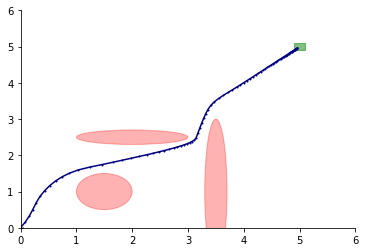

In [13]:
# Disable cvxopt optimiztaion output
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['max_iter'] = 1000

# Plot
fig, ax = plt.subplots()
jet = plt.get_cmap('jet')
colors = iter(jet(np.linspace(0, 1, len(xx)*len(yy))))

# Loop through initial conditions and simulate system
print('Computing trajectories for initial conditions:')
print('x_0\t x_1')
for idxi, i in enumerate(xx):
    for idxj, j in enumerate(yy):
        # If initial condition is inside the bad set, skip it.
        bool_val = 0
        curr_bs = []
        for idxk, k in enumerate(bad_sets):
            curr_bs = bad_sets[idxk]
            if cbf_utils.is_inside_ellipse([i, j], bad_sets[idxk]):
                print('Skip (Invalid):\t', i, j)
                bool_val = 1
        if bool_val == 1:
            continue

        print(round(i, 2), '\t', round(j, 2), "\t... ", end="", flush=True)
        x_0 = np.array([i, j])

        # Compute output on the nimble ant system for given initial conditions and timesteps T
        t, y, x = control.input_output_response(sys=nimble_ant_closed, T=T, U=0, X0=[
                                                i, j], return_x=True, method='BDF')

        # Plot initial conditions and path of system
        plt.plot(i, j, 'x-', markersize=3, color=[0, 0, 0, 1])
        plt.plot(x[0], x[1], 'o-', markersize=1,
                 color=next(colors, [1, 1, 1, 1]))

        print("Done")

ax = cbf_utils.plot_cbf_elements(ax, bad_sets, x_goal)

plt.xlim(0, 6)
plt.ylim(0, 6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()
